# 초기 설정 (마운트, 경로설정, 라이브러리 임포트)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/column_shap

/content/drive/MyDrive/Colab Notebooks/column_shap


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import statistics
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import f_oneway
from sklearn.datasets import fetch_openml
from scipy.stats import ks_2samp
from scipy.stats import f_oneway
from sklearn.model_selection import GridSearchCV
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_regression
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from scipy.stats.mstats import winsorize
import itertools
from scipy.stats import zscore

In [ ]:
!pip install tqdm  # tqdm 라이브러리 설치
from tqdm import tqdm  # tqdm 임포트

# 1차 함수 선언

100개 train/test split data set 뽑기

In [ ]:
def train_test_index(X_tmp,y_tmp,num):
  same_check=[0]
  while 0 in same_check:
    count=-1
    df_index_test=pd.DataFrame(columns=range(num))
    df_index_train=pd.DataFrame(columns=range(num))
    for ii in range(num):
      count_false_X=100
      count_false_y=100
      while  count_false_y>0:
        X_train, X_test, y_train, y_test = train_test_split(X_tmp,y_tmp,test_size=0.2,random_state=None,shuffle=True)
        mean_threshold_y=0.01*y_tmp.mean()
        std_threshold_y = 0.1 * y_tmp.std()
        a1=np.abs(y_tmp.mean()-y_train.mean())<mean_threshold_y
        a2=np.abs(y_tmp.mean()-y_test.mean())<mean_threshold_y
        a3=np.abs(y_tmp.std()-y_train.std())<std_threshold_y
        a4=np.abs(y_tmp.std()-y_test.std())<std_threshold_y
        data=a1,a2,a3,a4
        count_false_y=0
        for value in data:
          if value == False:
              count_false_y += 1
      df_index_test[ii]=sorted(X_test.index.tolist())
      df_index_train[ii]=sorted(X_train.index.tolist())
    # create dataframe with two empty columns
    dice = pd.DataFrame(columns=['col1', 'col2'])
    # loop through 10 natural numbers and randomly select two different numbers for each row
    for i in range(1, num+1):
        numbers = random.sample(range(0, num), 2)
        dice.loc[i-1] = numbers
    same_check=[]
    for i in range(num):
      same_check_tmp=np.sum(df_index_test[dice.iloc[i][0]]-df_index_test[dice.iloc[i][1]])
      same_check.append(same_check_tmp)
    count+=1
  return df_index_train, df_index_test


1개 train/test split data set 뽑기

In [ ]:
def train_test_index2(X_tmp,y_tmp):
  df_index_test=pd.DataFrame(columns=range(1))
  df_index_train=pd.DataFrame(columns=range(1))
  count_false_X=100
  count_false_y=100
  while  count_false_y>0:
  # Load your dataset as a Pandas DataFrame
    X_train, X_test, y_train, y_test = train_test_split(X_tmp,y_tmp,test_size=0.2,random_state=None,shuffle=True)
    mean_threshold_y=0.1*y_tmp.mean()
    std_threshold_y = 0.1 * y_tmp.std()
    a1=np.abs(y_tmp.mean()-y_train.mean())<mean_threshold_y
    a2=np.abs(y_tmp.mean()-y_test.mean())<mean_threshold_y
    a3=np.abs(y_tmp.std()-y_train.std())<std_threshold_y
    a4=np.abs(y_tmp.std()-y_test.std())<std_threshold_y
    data=a1,a2,a3,a4
    count_false_y=0
    for value in data:
      if value == False:
          count_false_y += 1
  df_index_test=sorted(X_test.index.tolist())
  df_index_train=sorted(X_train.index.tolist())
  return df_index_train, df_index_test

초기 파라메터 튜닝

In [ ]:
def initial_tuning(X_tmp,y_tmp):
  base_score_value=np.mean(y_tmp)
  model = xgb.XGBRegressor(objective='reg:squarederror',
                          base_score=base_score_value)
  X_train, X_test, y_train, y_test = train_test_split(X_tmp,y_tmp, test_size=0.2, random_state=None,shuffle=True)
  param_grid = {
      'max_depth': [3,5,7],
      'min_child_weight': [0.05,0.075,0.1],
      'gamma': [0.001,0.005,0.01,0.015,0.02],
      'reg_alpha': [0.01,0.05,0.1],
      'reg_lambda': [0.01,0.05,0.1],
  }
  df_param_grid=pd.DataFrame(param_grid.items())

  param_step1 = {
      df_param_grid.iloc[0,0]: df_param_grid.iloc[0,1],
      df_param_grid.iloc[1,0]: df_param_grid.iloc[1,1],
  }

  grid_search_step1 = GridSearchCV(model, param_grid=param_step1, cv=10, n_jobs=-1,scoring='neg_mean_squared_error')
  grid_search_step1.fit(X_train, y_train)

  model_0 = xgb.XGBRegressor(objective='reg:squarederror',
                                base_score=base_score_value,
                                **grid_search_step1.best_params_)
  ## step 2
  param_step2 = {
      df_param_grid.iloc[2,0]: df_param_grid.iloc[2,1],
      df_param_grid.iloc[3,0]: df_param_grid.iloc[3,1],
      df_param_grid.iloc[4,0]: df_param_grid.iloc[4,1],
  }
  grid_search_step2 = GridSearchCV(model, param_grid=param_step2, cv=10, n_jobs=-1)
  grid_search_step2.fit(X_train, y_train)

  step1_best_params_=grid_search_step1.best_params_
  step2_best_params_=grid_search_step2.best_params_
  return step1_best_params_,step2_best_params_

# 2차 함수 선언

## 데이터베이스 입력+data preprocessing

In [ ]:
def data_input(target_num):
  df = pd.read_csv("df_275samples_1030.csv", encoding='cp949')
  # df=df_tmp.dropna(); # DS4 일때만

  # pt = PowerTransformer(method='yeo-johnson')
  minmax = MinMaxScaler()
  # trans = pt.fit_transform(df)
  # df_trans=pd.DataFrame(trans)
  # df_trans[df_trans.columns]=minmax.fit_transform(df_trans[df_trans.columns])
  df[df.columns]=minmax.fit_transform(df[df.columns])
  df_output=df.iloc[:, -8:]
  df_input=df.iloc[:,:-8]
  X = df_input
  y = df_output.iloc[:,target_num]
  # ["DS1", "DS2","DS3","DS4", "Vy","Vu","DS4/DS2"]
  return X,y

In [ ]:
def data_input_nopre(target_num):
  df_tmp = pd.read_csv("df_278samples_1018.csv", encoding='cp949')
  df=df_tmp.dropna(); # DS4 일때만

  # pt = PowerTransformer(method='yeo-johnson')
  # minmax = MinMaxScaler()
  # trans = pt.fit_transform(df)
  # df_trans=pd.DataFrame(trans)
  # df_trans[df_trans.columns]=minmax.fit_transform(df_trans[df_trans.columns])
  df_output=df.iloc[:, -8:]
  df_input=df.iloc[:,:-8]
  X = df_input
  y = df_output.iloc[:,target_num]
  # ["DS1", "DS2","DS3","DS4", "Vy","Vu","DS4/DS2"]
  return X,y

## 이상치제거

In [ ]:
def outlier_eliminater(X,y,num,var1,var2,var3,step1_best_params_,step2_best_params_):
  threshold = (y.mean() * var1) ** 2
  X_rsod=X
  y_rsod=y
  num=num
  remove_ind=[]
  remove_df = pd.DataFrame(index=range(round(0.2*len(y_rsod))), columns=range(num))
  # step1_best_params_,step2_best_params_ = initial_tuning(X_rsod,y_rsod)
  for iii in range (num): # outlier list 만들어 낼 case 개수
    remove_list=[]
    while len(remove_list)<var2: # 빈도 파악할 outlier 개수
      min_score = 1000
      base_score_value=np.median(y_rsod)
      for i in range(1): # removing set의 필터링
        df_index_train,df_index_test=train_test_index2(X_rsod,y_rsod)
        X_train=X_rsod.loc[df_index_train]
        y_train=y_rsod.loc[df_index_train]
        X_test=X_rsod.loc[df_index_test]
        y_test=y_rsod.loc[df_index_test]
        model = xgb.XGBRegressor(objective='reg:squarederror',
                              base_score=base_score_value,
                              **step1_best_params_,
                              **step2_best_params_
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        score = mean_squared_error(y_test, preds)**0.5
        if score < min_score:
          remove_train = X_test
          remove_test = preds
          min_score = score

      pred_value = remove_test.tolist()
      remove_set = remove_train.reset_index()["index"].to_list()
      real_value = []

      for ii in remove_set:
        real_value.append(y[ii])

      count = 0
      for p, r in zip(pred_value, real_value):
        temp = (p - r) ** 2
        if temp > threshold:
          remove_ind.append(remove_set[count])
        count += 1

      remove_list.extend(remove_ind)
      X_rsod=X.drop(remove_list,axis=0)
      y_rsod=y.drop(remove_list,axis=0)
      remove_ind=[]
      for a in range  (len(remove_list)):
        remove_df[iii][a]=remove_list[a]

  tmp=remove_df.values.flatten().tolist()
  ttmp=[x for x in tmp if not pd.isna(x)]
  counts = Counter(ttmp)
  # Get the 5 most common values and their counts
  top_5 = counts.most_common(round(var3*len(y)))  # 최종 제거할 outlier 개수
  real_remove_df=pd.DataFrame(top_5)[0]

  X_rsod=X.drop(real_remove_df,axis=0)
  y_rsod=y.drop(real_remove_df,axis=0)
  return X_rsod,y_rsod,real_remove_df,model

In [ ]:
def model_rsod(target_num,num,num2,var1,var2,var3,step1_best_params_,step2_best_params_):
  X,y=data_input(target_num)
  X_rsod,y_rsod,real_remove_df,model =outlier_eliminater(X,y,num,var1,var2,var3,step1_best_params_,step2_best_params_) #이상치 제거
  base_score_value=np.median(y)
  # step1_best_params_,step2_best_params_  =  initial_tuning(X_rsod,y_rsod)
  model = xgb.XGBRegressor(objective='reg:squarederror',
                        base_score=base_score_value,
                        **step1_best_params_,
                        **step2_best_params_)
  num2=num2
  r2_test=0
  r2_train_result=[]
  r2_test_result=[]
  df_index_train,df_index_test,count=train_test_index(X_rsod,y_rsod,num2)

  for i in range(num2):
    X_train=X_rsod.loc[df_index_train[i]]
    y_train=y_rsod.loc[df_index_train[i]]
    X_test=X_rsod.loc[df_index_test[i]]
    y_test=y_rsod.loc[df_index_test[i]]


    model.fit(X_train, y_train)
    # Predict on the test set
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Compute the R-squared for the test set
    r2_train = r2_score(y_train,y_train_pred)
    r2_test = r2_score(y_test,y_test_pred)

    r2_train_result.append(r2_train)
    r2_test_result.append(r2_test)
  return r2_test_result,X_rsod,y_rsod

## 차원축소

In [ ]:
def fs1(X_rsod,y_rsod,num,step1_best_params_,step2_best_params_):
  num=num
  ranking_df = pd.DataFrame(index=range(X_rsod.shape[1]), columns=range(num))
  # step1_best_params_,step2_best_params_  =  initial_tuning(X_rsod,y_rsod)
  base_score_value=np.mean(y_rsod)
  df_index_train,df_index_test,count=train_test_index(X_rsod,y_rsod,num)
  for i in range(num):
    X_train=X_rsod.loc[df_index_train[i]]
    y_train=y_rsod.loc[df_index_train[i]]
    X_test=X_rsod.loc[df_index_test[i]]
    y_test=y_rsod.loc[df_index_test[i]]
    model_fs1 = XGBRegressor(objective='reg:squarederror',
                                  base_score=base_score_value,
                                  **step1_best_params_,
                                  **step2_best_params_
                                  )
    model_fs1.fit(X_train, y_train)
    importances = model_fs1.feature_importances_

    # Print the feature importances in descending order
    indices = importances.argsort()[::-1]
    ranking_df[i]=indices

  row_avg = ranking_df.mean(axis=1)
  good_feature=row_avg[row_avg<np.mean(row_avg)+0.5].index
  X_fs1=X_rsod.iloc[:, good_feature]
  y_fs1=y_rsod
  return X_fs1,y_fs1,model_fs1

## 튜닝

In [ ]:
# tuning 수행할 dataset 탐색
def tuning_dataset(X_fs1,y_fs1,num,model_fs1):
  num=num
  r2_test_hype=0
  r2_train_hype_result=[]
  r2_test_hype_result=[]
  df_index_train,df_index_test,count=train_test_index(X_fs1,y_fs1,num)
  for ii in range(num):
    X_train=X_fs1.loc[df_index_train[ii]]
    y_train=y_fs1.loc[df_index_train[ii]]
    X_test=X_fs1.loc[df_index_test[ii]]
    y_test=y_fs1.loc[df_index_test[ii]]

    model_fs1.fit(X_train, y_train)
    # Predict on the test set
    y_test_pred = model_fs1.predict(X_test)
    y_train_pred = model_fs1.predict(X_train)

    # Compute the R-squared for the test set
    r2_train_hype = r2_score(y_train,y_train_pred)
    r2_test_hype = r2_score(y_test,y_test_pred)
    r2_train_hype_result.append(r2_train_hype)
    r2_test_hype_result.append(r2_test_hype)

  max_r2= max(r2_test_hype_result)
  max_index = r2_test_hype_result.index(max_r2)
  i=max_index
  X_train=X_fs1.loc[df_index_train[i]]
  y_train=y_fs1.loc[df_index_train[i]]
  X_test=X_fs1.loc[df_index_test[i]]
  y_test=y_fs1.loc[df_index_test[i]]

  return X_train,y_train,X_test,y_test,df_index_test[i]

In [ ]:
def tuning(X_train,y_train,X_test,y_test,model_fs1):
  param_grid = {
      'learning_rate': [0.075,0.1,0.125,0.15],
      'subsample': [0.1,0.2,0.35,0.5],
      'colsample_bytree': [0.25,0.5,0.75,1],
      'n_estimators': [70,100,120,150],
      'max_depth': [3,5,7,9],
      'min_child_weight': [0.001,0.005,0.0075,0.01],
      'scale_pos_weight':[0.001,0.005,0.0075,0.01],
      'gamma': [0.003,0.005,0.007,0.01],
      'reg_alpha': [0.02,0.025,0.03,0.05],
      'reg_lambda': [0.075,0.01,0.0125,0.015],
  }
  df_param_grid=pd.DataFrame(param_grid.items())
  base_score_value=np.mean(y_train)
  # df_index_train,df_index_test=train_test_index2(X_fs1,y_fs1)
  # X_train=X_fs1.loc[df_index_train]
  # y_train=y_fs1.loc[df_index_train]
  # X_test=X_fs1.loc[df_index_test]
  # y_test=y_fs1.loc[df_index_test]
  ## step 1
  param_step1 = {
      df_param_grid.iloc[0,0]: df_param_grid.iloc[0,1],
      df_param_grid.iloc[1,0]: df_param_grid.iloc[1,1]
  }
  grid_search_step1 = GridSearchCV(model_fs1, param_grid=param_step1, cv=10, n_jobs=-1,scoring='neg_mean_squared_error')
  grid_search_step1.fit(X_train, y_train)

  model_hype = xgb.XGBRegressor(objective='reg:squarederror',
                                base_score=base_score_value,
                                **grid_search_step1.best_params_)

  ## step 2
  param_step2 = {
      df_param_grid.iloc[2,0]: df_param_grid.iloc[2,1],
      df_param_grid.iloc[3,0]: df_param_grid.iloc[3,1]
  }
  grid_search_step2 = GridSearchCV(model_hype, param_grid=param_step2, cv=10, n_jobs=-1)
  grid_search_step2.fit(X_train, y_train)

  model_hype = XGBRegressor(objective='reg:squarederror',
                                base_score=base_score_value,
                                **grid_search_step1.best_params_,
                                **grid_search_step2.best_params_)

  # step 3
  param_step3 = {
      df_param_grid.iloc[4,0]: df_param_grid.iloc[4,1],
      df_param_grid.iloc[5,0]: df_param_grid.iloc[5,1]
  }
  grid_search_step3 = GridSearchCV(model_hype, param_grid=param_step3, cv=10, n_jobs=-1)
  grid_search_step3.fit(X_train, y_train)

  model_hype = XGBRegressor(objective='reg:squarederror',
                                base_score=base_score_value,
                                **grid_search_step1.best_params_,
                                **grid_search_step2.best_params_,
                                **grid_search_step3.best_params_)

  # step 4
  param_step4 = {
      df_param_grid.iloc[6,0]: df_param_grid.iloc[6,1],
      df_param_grid.iloc[7,0]: df_param_grid.iloc[7,1]
  }
  grid_search_step4 = GridSearchCV(model_hype, param_grid=param_step4, cv=10, n_jobs=-1)
  grid_search_step4.fit(X_train, y_train)

  model_hype = XGBRegressor(objective='reg:squarederror',
                                base_score=base_score_value,
                                **grid_search_step1.best_params_,
                                **grid_search_step2.best_params_,
                                **grid_search_step3.best_params_,
                                **grid_search_step4.best_params_)

  # step 5
  param_step5 = {
      df_param_grid.iloc[8,0]: df_param_grid.iloc[8,1],
      df_param_grid.iloc[9,0]: df_param_grid.iloc[9,1]
  }
  grid_search_step5 = GridSearchCV(model_hype, param_grid=param_step5, cv=10, n_jobs=-1)
  grid_search_step5.fit(X_train, y_train)

  model_hype_result = XGBRegressor(objective='reg:squarederror',
                                base_score=base_score_value,
                                **grid_search_step1.best_params_,
                                **grid_search_step2.best_params_,
                                **grid_search_step3.best_params_,
                                **grid_search_step4.best_params_,
                                **grid_search_step5.best_params_)
  parameters=[grid_search_step1.best_params_,
            grid_search_step2.best_params_,
            grid_search_step3.best_params_,
            grid_search_step4.best_params_,
            grid_search_step5.best_params_]
  return model_hype_result

## 성능평가

In [ ]:
# tuning 수행된 모델 성능 평가
def model_eval_100(X_fs1,y_fs1,model_hype_result):
  num=100
  r2_test_hype=0
  r2_train_hype_result=[]
  r2_test_hype_result=[]
  df_index_train,df_index_test,count=train_test_index(X_fs1,y_fs1,num)
  for ii in range(num):
    X_train=X_fs1.loc[df_index_train[ii]]
    y_train=y_fs1.loc[df_index_train[ii]]
    X_test=X_fs1.loc[df_index_test[ii]]
    y_test=y_fs1.loc[df_index_test[ii]]

    model_hype_result.fit(X_train, y_train)
    # Predict on the test set
    y_test_pred = model_hype_result.predict(X_test)
    y_train_pred = model_hype_result.predict(X_train)

    # Compute the R-squared for the test set
    r2_train_hype = r2_score(y_train,y_train_pred)
    r2_test_hype = r2_score(y_test,y_test_pred)

    r2_train_hype_result.append(r2_train_hype)
    r2_test_hype_result.append(r2_test_hype)

  max_r2= max(r2_test_hype_result)
  max_index = r2_test_hype_result.index(max_r2)
  i=max_index
  X_train=X_fs1.loc[df_index_train[i]]
  y_train=y_fs1.loc[df_index_train[i]]
  X_test=X_fs1.loc[df_index_test[i]]
  y_test=y_fs1.loc[df_index_test[i]]
  return X_train,y_train,X_test,y_test,df_index_train[i],df_index_test[i],max_r2,r2_test_hype_result

In [ ]:
def cv_model_eval(model_hype_result,X_fs1,y_fs1):
  avg_r2_hype=0
  cv_results_r2_hype = []
  df_index_train,df_index_test=train_test_index2(X_fs1,y_fs1)
  X_train=X_fs1.loc[df_index_train]
  y_train=y_fs1.loc[df_index_train]
  for _ in range(10):
    avg_r2_hype_result=[]
    kfold=KFold(n_splits=10, shuffle=True,random_state=None)
    for train_index, val_index in kfold.split(X_train):
        X_train_k, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_k, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        model_hype_result.fit(X_train_k, y_train_k)
        y_val_pred = model_hype_result.predict(X_val)
        r2_hype=r2_score(y_val, y_val_pred)
        avg_r2_hype_result.append(r2_hype)
    cv_results_r2_hype.append(np.mean(avg_r2_hype_result))
  return cv_results_r2_hype

## 결과 뽑기

In [ ]:
def result(X_train,y_train,X_test,y_test,df_index_train,df_index_test,model_hype_result):
  # max_r2= max(r2_test_hype_result)
  # max_index = r2_test_hype_result.index(max(r2_test_hype_result))
  # ii=max_index
  # X_train=X_fs1.loc[df_index_train[ii]]
  # y_train=y_fs1.loc[df_index_train[ii]]
  # X_test=X_fs1.loc[df_index_test[ii]]
  # y_test=y_fs1.loc[df_index_test[ii]]
  model_hype_result.fit(X_train, y_train)
  y_train_pred=model_hype_result.predict(X_train)
  y_test_pred = model_hype_result.predict(X_test)
  r2_test_hype = r2_score(y_test,y_test_pred)
  array_1=df_index_test.to_numpy()
  array_2=y_test
  array_3=y_test_pred
  array_4=df_index_train.to_numpy()
  array_5=y_train
  array_6=y_train_pred
  result_df2 = pd.DataFrame({'index': array_1, 'real': array_2, 'preds': array_3})
  result_df1= pd.DataFrame({'index': array_4, 'real': array_5, 'preds': array_6})
  return result_df1,result_df2

In [ ]:
def result(X_train,y_train,X_test,y_test,df_index_test,model_hype_result):
  max_r2= max(r2_test_hype_result)
  max_index = r2_test_hype_result.index(max(r2_test_hype_result))
  ii=max_index
  X_train=X_fs1.loc[df_index_train[ii]]
  y_train=y_fs1.loc[df_index_train[ii]]
  X_test=X_fs1.loc[df_index_test[ii]]
  y_test=y_fs1.loc[df_index_test[ii]]
  model_hype_result.fit(X_train, y_train)
  y_test_pred = model_hype_result.predict(X_test)
  r2_test_hype = r2_score(y_test,y_test_pred)

  array_1=df_index_test.to_numpy()
  array_2=y_test
  array_3=y_test_pred
  result_df = pd.DataFrame({'index': array_1, 'real': array_2, 'preds': array_3})
  return result_df

## 역변환

In [ ]:
# def inverse_transe(result_df,target_num):
#   df_tmp = pd.read_csv("df_278samples_1026.csv", encoding='cp949')
#   df=df_tmp.dropna();

#   df.astype('float')
#   df_output=df.iloc[:, :-8]
#   df_input=df.iloc[:,-8:]

#   X = df_input
#   y = np.array(df_output.iloc[:,target_num])

#   pt = PowerTransformer(method='yeo-johnson')
#   scaler = MinMaxScaler()
#   y_pt = pt.fit_transform(y.reshape(-1, 1))
#   y_scaled = scaler.fit_transform(y_pt)

#   # 예측값 불러오기
#   y_test=result_df['real']
#   y_test_pred=result_df['preds']
#   y_pred_scaled=y_test_pred
#   # 7. 예측값 역변환
#   y_pred_pt = scaler.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1))
#   y_pred_inverse = pt.inverse_transform(y_pred_pt)
#   # 8.실제값 역변환
#   y_test_pt = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
#   y_test_inverse = pt.inverse_transform(y_test_pt)

#   # 9. 역변환 안되는놈 그냥 제거
#   result_df = result_df[~np.isnan(y_pred_inverse)]
#   y_test_pt = y_test_pt[~np.isnan(y_pred_inverse)]
#   y_pred_inverse = y_pred_inverse[~np.isnan(y_pred_inverse)]
#   y_test_inverse = y_test_inverse[~np.isnan(y_pred_inverse)]

#   arr0=result_df['index']
#   arr1=y[arr0].ravel()
#   arr2=y_test_inverse.ravel()
#   arr3=y_pred_inverse.ravel()
#   inverse_result =pd.DataFrame({'index': arr0}) # 예시 DataFrame
#   inverse_result['test']=arr1
#   inverse_result['inverse'] = arr2
#   inverse_result['preds'] = arr3
#   return inverse_result

In [ ]:
def inverse_transe(target_num,y_test,y_pred,y_test_c,y_pred_c):
  df_tmp = pd.read_csv("df_275samples_1030.csv", encoding='cp949')
  df=df_tmp.dropna();

  df.astype('float')
  df_output=df.iloc[:, -8:]
  df_input=df.iloc[:,:-8]

  X = df_input
  y = np.array(df_output.iloc[:,target_num])
  scaler = MinMaxScaler()
  y_scaled = scaler.fit_transform(y.reshape(-1, 1))
#before
  y_pred_inverse = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
  y_test_inverse = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
  #after
  y_pred_inverse_c = scaler.inverse_transform(np.array(y_pred_c).reshape(-1, 1))
  y_test_inverse_c  = scaler.inverse_transform(np.array(y_test_c).reshape(-1, 1))

  return y_test_inverse,y_pred_inverse,y_test_inverse_c,y_pred_inverse_c

In [ ]:
# def inverse_transe(target_num,y_test,y_pred,y_test_c,y_pred_c):
#   df_tmp = pd.read_csv("df_278samples_1026.csv", encoding='cp949')
#   df=df_tmp.dropna();

#   df.astype('float')
#   df_output=df.iloc[:, :-8]
#   df_input=df.iloc[:,-8:]

#   X = df_input
#   y = np.array(df_output.iloc[:,target_num])

#   pt = PowerTransformer(method='yeo-johnson')
#   scaler = MinMaxScaler()
#   y_pt = pt.fit_transform(y.reshape(-1, 1))
#   y_scaled = scaler.fit_transform(y_pt)

# #before
#   y_pred_pt = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
#   y_pred_inverse = pt.inverse_transform(y_pred_pt)
#   y_test_pt = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
#   y_test_inverse = pt.inverse_transform(y_test_pt)

#   #after
#   y_pred_pt_c = scaler.inverse_transform(np.array(y_pred_c).reshape(-1, 1))
#   y_pred_inverse_c = pt.inverse_transform(y_pred_pt_c)
#   y_test_pt_c = scaler.inverse_transform(np.array(y_test_c).reshape(-1, 1))
#   y_test_inverse_c = pt.inverse_transform(y_test_pt_c)

#   return y_test_inverse,y_pred_inverse,y_test_inverse_c,y_pred_inverse_c

In [ ]:
# y_pred_t

In [ ]:
#  df = pd.read_csv("df_278samples_1026.csv", encoding='cp949')
#   # df=df_tmp.dropna();

# df.astype('float')
# df_output=df.iloc[:, :-8]
# df_input=df.iloc[:,-8:]

# X = df_input
# y = np.array(df_output.iloc[:,target_num])
# scaler = MinMaxScaler()
# y_scaled = scaler.fit_transform(y.reshape(-1, 1))

# #before
# y_pred_inverse = scaler.inverse_transform(np.array(y_pred_t).reshape(-1, 1))
# y_test_inverse = scaler.inverse_transform(np.array(y_test_t).reshape(-1, 1))

In [ ]:
# y_test_inverse

In [ ]:
def inverse_transe_ini(target_num,y_test_t,y_pred_t):
  df = pd.read_csv("df_275samples_1030.csv", encoding='cp949')
  # df=df_tmp.dropna();

  df.astype('float')
  df_input=df.iloc[:, :-8]
  df_output=df.iloc[:,-8:]

  X = df_input
  y = np.array(df_output.iloc[:,target_num])
  scaler = MinMaxScaler()
  y_scaled = scaler.fit_transform(y.reshape(-1, 1))

#before
  y_pred_inverse = scaler.inverse_transform(np.array(y_pred_t).reshape(-1, 1))
  y_test_inverse = scaler.inverse_transform(np.array(y_test_t).reshape(-1, 1))
  return y_test_inverse,y_pred_inverse

# 모델 구축

## 변환 전후 분포 변화

In [ ]:
# t_df = pd.read_csv("df_278samples_1026.csv", encoding='cp949')
t_df = pd.read_csv("df_275samples_1030.csv", encoding='cp949')
minmax = MinMaxScaler()
t_df[t_df.columns]=minmax.fit_transform(t_df[t_df.columns])
t_df_output=t_df.iloc[:, -8:]
t_df_input=t_df.iloc[:,:-8]

df = pd.read_csv("df_275samples_1030.csv", encoding='cp949')
df_output=df.iloc[:, -8:]
df_input=df.iloc[:,:-8]
samples = sorted(np.random.choice(t_df_input.index, size=5))
samples = [26,38,53,84,157]

샘플별 변화

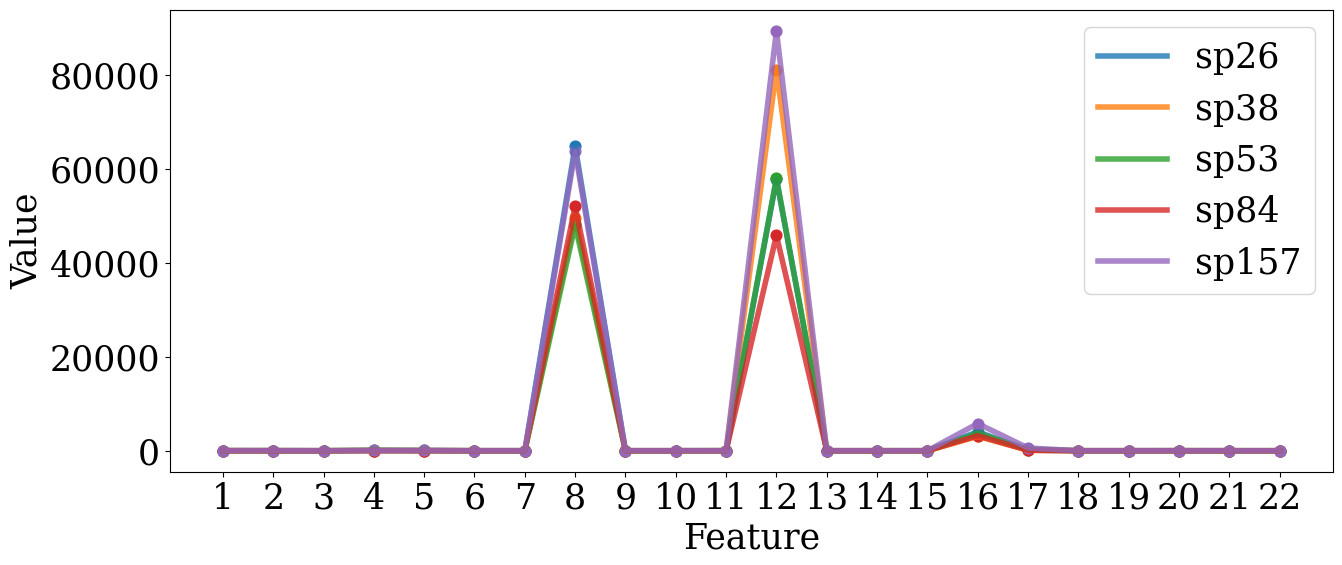

In [ ]:
# plot을 생성합니다.
plt.figure(figsize=(12, 6))
for i in samples:
    # 데이터 포인트를 표시합니다.
    plt.scatter(range(len(df_input.columns)), df_input.loc[i, :], marker='o', s=60)

    # 선으로 이어줍니다.
    plt.plot(range(len(df_input.columns)), df_input.loc[i, :], alpha=0.8,label=f"sp{i}",linewidth=4)

# x축과 y축의 label을 설정합니다.
plt.xlabel("Feature",fontsize=25)
plt.ylabel("Value",fontsize=25)
# plt.xticks(range(len(df_input.columns)), df_input.columns)
plt.xticks(range(len(t_df_input.columns)),range(1, len(t_df_input.columns)+ 1), fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
# plt.title("[Before scaling]", fontsize=17)
# plt.annotate("<Before scaling>", (0.5, 1.05), fontsize=20, ha="center", va="top")

# plt.text(0.5, 1.05, "Before scaling", fontsize=20, horizontalalignment="center", verticalalignment="center")
plt.show()

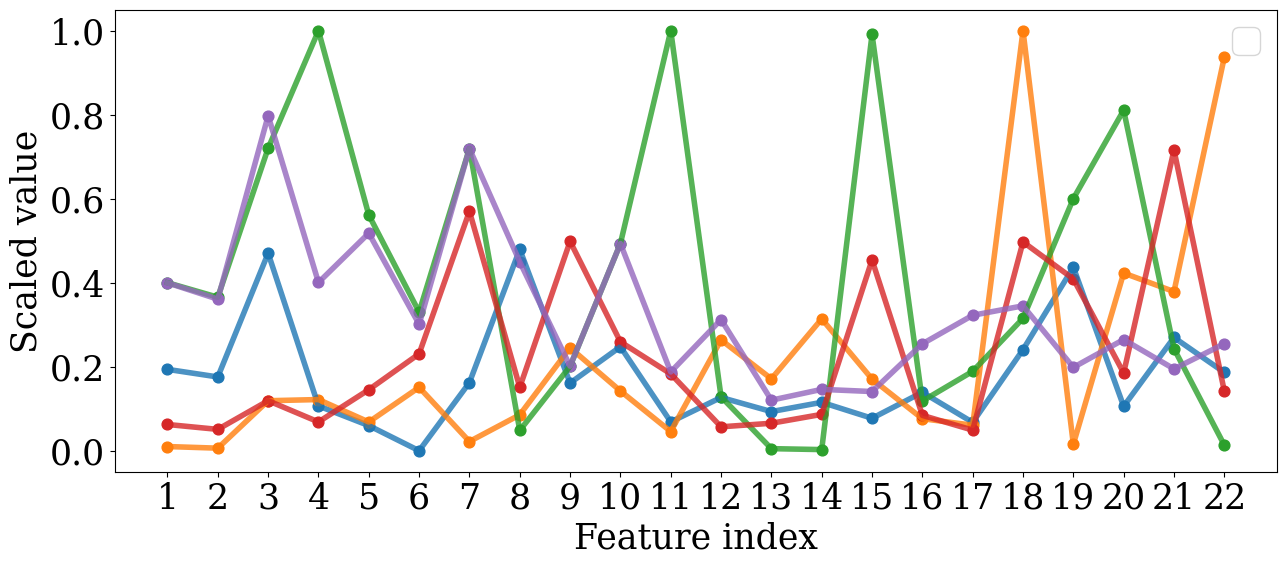

In [ ]:
# plot을 생성합니다.
plt.figure(figsize=(15, 6))
for i in samples:
    plt.scatter(range(len(t_df_input.columns)), t_df_input.loc[i, :], marker='o', s=60)
    plt.plot(range(len(t_df_input.columns)), t_df_input.loc[i, :], alpha=0.8,linewidth=4)

# x축과 y축의 label을 설정합니다.
plt.xlabel("Feature index",fontsize=25)
plt.ylabel("Scaled value",fontsize=25)
plt.xticks(range(len(t_df_input.columns)),range(1, len(t_df_input.columns)+ 1), fontsize=25)
plt.yticks(fontsize=25)
plt.legend()
# plt.title("[After scaling]", fontsize=17)
plt.show()

<ipython-input-47-bdf7cecf8eed>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(t_df_input[features], shade=False, alpha=0.5)


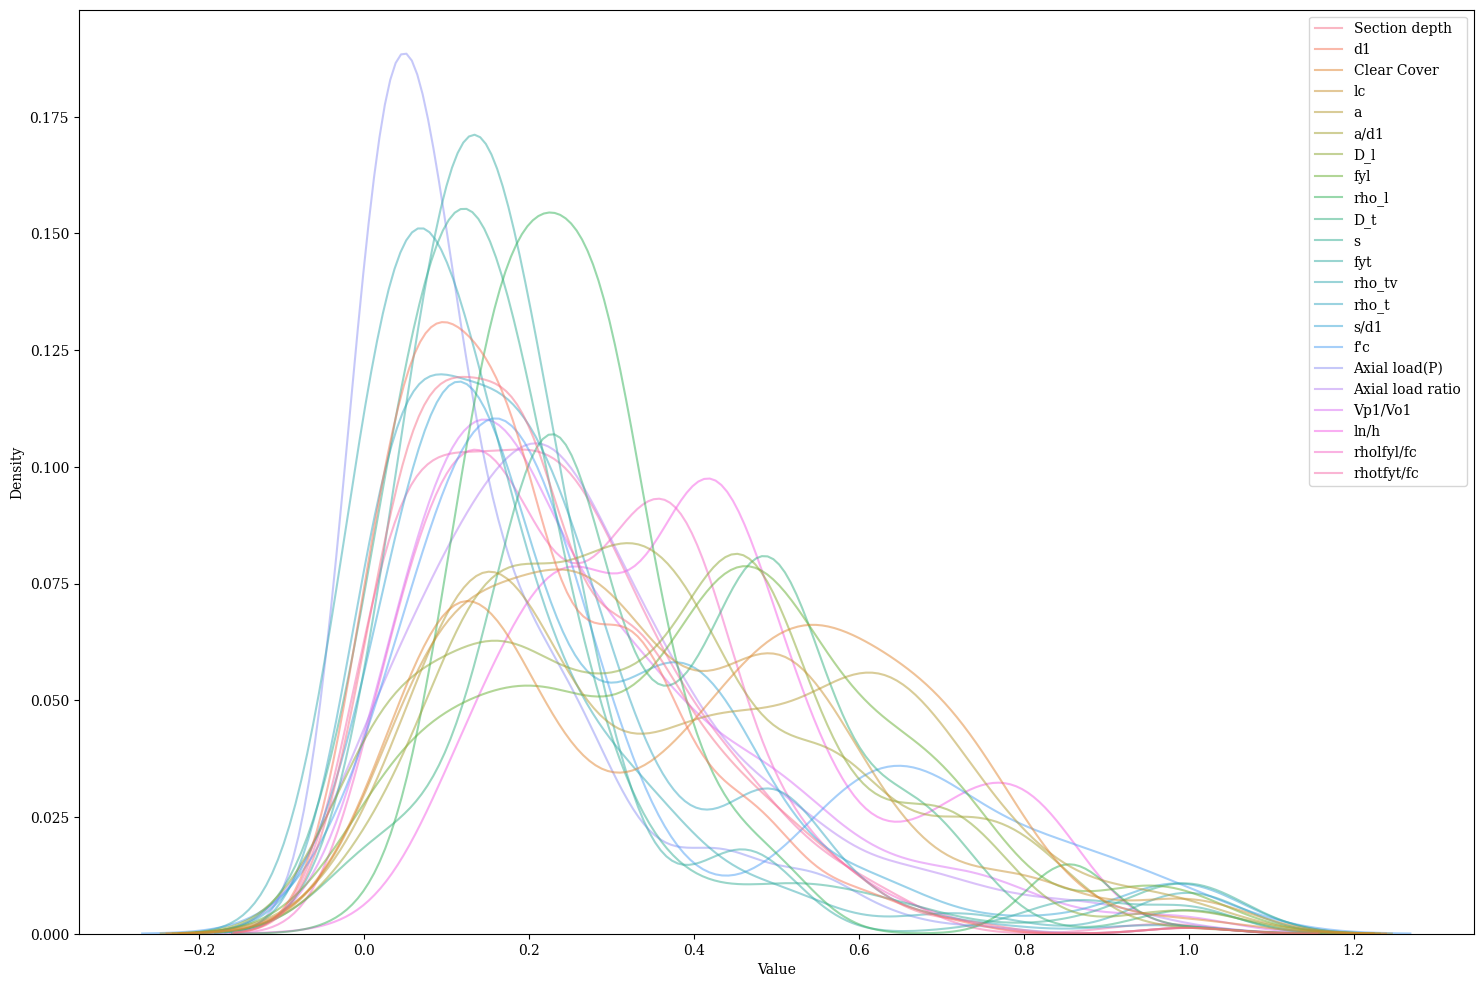

In [ ]:
features = list(t_df_input.columns)

# 모든 feature의 kde 분포를 한개의 plot에 나타냅니다.
plt.figure(figsize=(18, 12))
sns.kdeplot(t_df_input[features], shade=False, alpha=0.5)
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

## 데이터 변환@@@@@@

In [ ]:
target_num=0
# df = pd.read_csv("df_278samples_1026.csv", encoding='cp949')
df = pd.read_csv("df_275samples_1030.csv", encoding='cp949')
df_output=df.iloc[:, -8:]
df_input=df.iloc[:,:-8]
X=df_input
y=df_output.iloc[:,target_num]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None,shuffle=True)
df_index_test=sorted(X_test.index.tolist())
df_index_train=sorted(X_train.index.tolist())
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=None)
model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = model.predict(X_test)
r2_before= r2_score(y_test, y_pred)
r2_before

0.5780420503163424

In [ ]:
t_df = pd.read_csv("df_275samples_1030.csv", encoding='cp949')
minmax = MinMaxScaler()
t_df[t_df.columns]=minmax.fit_transform(t_df[t_df.columns])
t_df_output=t_df.iloc[:, -8:]
t_df_input=t_df.iloc[:,:-8]

X=t_df_input
y=t_df_output.iloc[:,target_num]
X_train=X.loc[df_index_train]
y_train=y.loc[df_index_train]
X_test=X.loc[df_index_test]
y_test_t=y.loc[df_index_test]

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=None)
model.fit(X_train, y_train)
# Make predictions on the test set
y_pred_t = model.predict(X_test)
r2_t= r2_score(y_test_t, y_pred_t)

In [ ]:
y_test_t,y_pred_t=inverse_transe_ini(target_num,y_test_t,y_pred_t)
r2_before= r2_score(y_test, y_pred)
r2_after= r2_score(y_test_t, y_pred_t)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

target_name=["theta_y","theta_c","theta_u","V_y","V_c","V_u","theta_E","V_E"]
guide = np.max([np.max(y_test_t),np.max(y_pred_t),np.max(y_test),np.max(y_pred)])*1.02
line_data = [0.0, guide]
line_test = [0.0, guide]
plt.figure(figsize=(7, 7))
plt.rc('font', size=20)
plt.margins(x=0, y=0)

actual_values = y_test
predicted_values = y_pred
r_squared = r2_score(actual_values, predicted_values)

actual_values_t = y_test_t
predicted_values_t = y_pred_t
r_squared_c = r2_score(actual_values_t, predicted_values_t)

ax = plt.scatter(actual_values, predicted_values, color="black", s=70, edgecolor="black", facecolors="#888888")
ax.set_label('before')
ax1 = plt.scatter(actual_values_t, predicted_values_t, color="#880000", s=70, marker="^", edgecolor="black", facecolors="#800000")
ax1.set_label('after')

plt.xlabel("Measured drift ratio​ [rad]​")
plt.ylabel("Predicted drift ratio [rad]​​")

plt.plot(line_data, line_data, color="black", linestyle='dashed')
plt.legend(loc="lower right")
plt.grid()
text = f"R-squared before: {r2_before:.2f}\nR-squared after: {r2_after:.2f}"
bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2)
plt.text(0.02, 0.98, f"R² before (a) = {r_squared:.3f}\nR² after (a) ={r_squared_c:.3f}",
         bbox=bbox_props, transform=plt.gca().transAxes, ha="left", va="top")
plt.xticks(np.arange(0, guide, 0.005))
plt.yticks(np.arange(0, guide, 0.005))
plt.show()


NameError: ignored

## 이상치 탐색@@@@@@

In [ ]:
target_num=0
X,y=data_input(target_num)
X_train=X.loc[df_index_train]
y_train=y.loc[df_index_train]
X_test=X.loc[df_index_test]
y_test=y.loc[df_index_test]

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np


# Initialize and train an XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=None)
model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = model.predict(X_test)
r2_before= r2_score(y_test, y_pred)
# Calculate residuals
residuals = y_test- y_pred
print(r2_before)

0.5984820531896575


In [ ]:
from scipy.stats import zscore
z_scores = zscore(residuals)

# Define a threshold for outlier detection (e.g., Z-score > 3)
threshold = 1.5
mean = np.mean(residuals)
std = np.std(residuals)
# z_score를 residual로 변환합니다.
threshold_residual = threshold * std + mean
n_threshold_residual = -threshold * std + mean

# Identify outliers
outliers = (np.abs(z_scores) > threshold)
# Get the row indices where the condition is True
# outliers_index= outliers.any(axis=1).nonzero()[0]
outliers = np.where(np.abs(z_scores) > threshold)[0]
outliers_index=X_test.index[outliers]
residuals1=residuals.drop(outliers_index)


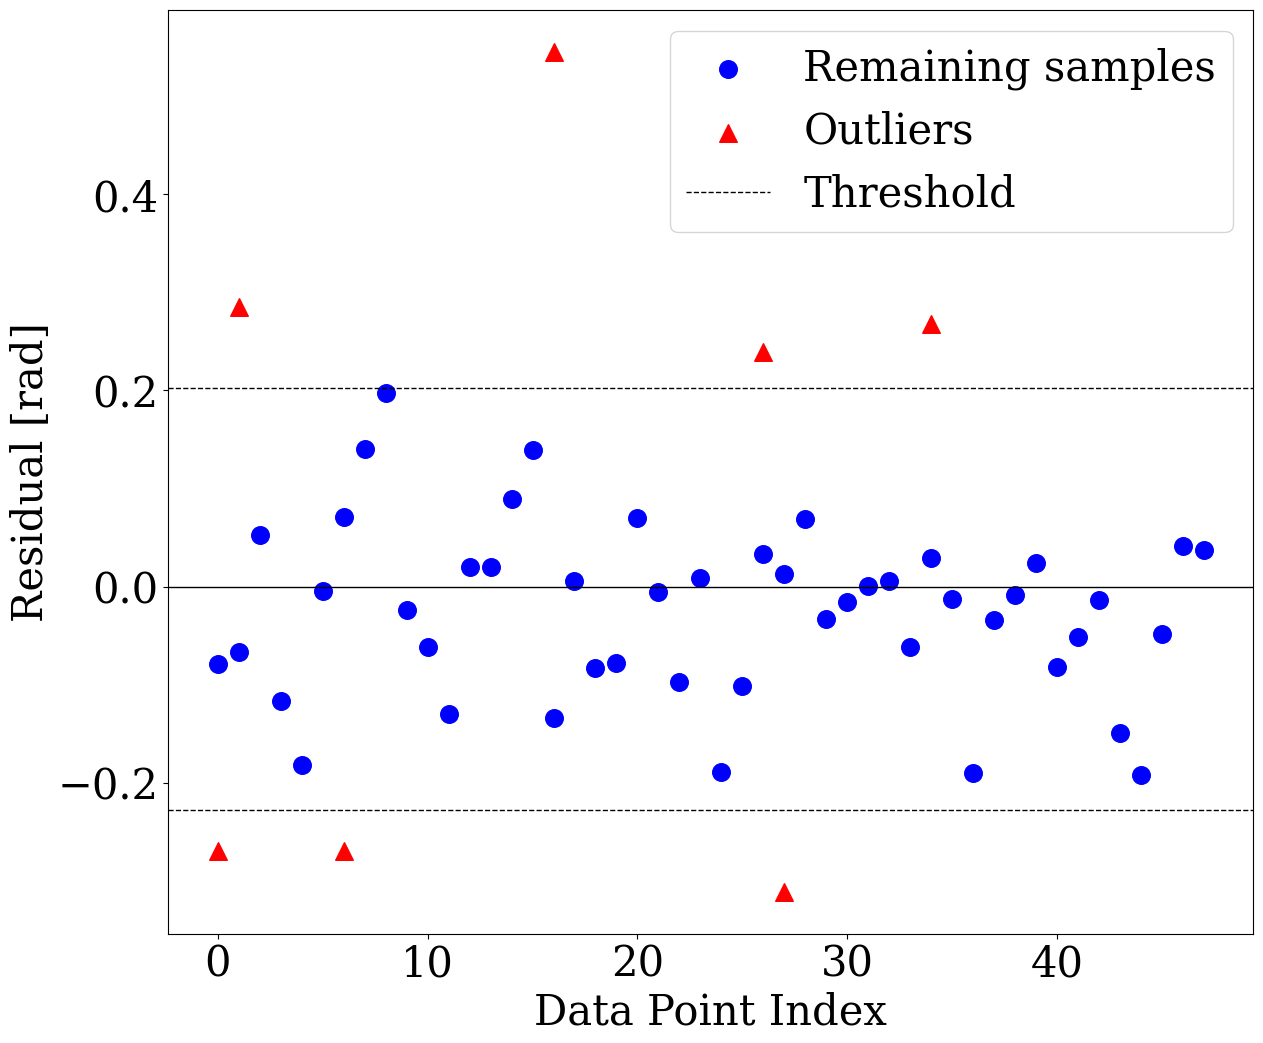

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 12))
plt.rc('font', size=30)
plt.scatter(range(len(residuals1)), residuals1, c='b', label='Remaining samples',s=160)
plt.scatter(outliers, residuals[outliers_index], c='r', label='Outliers',marker='^',s=160)
plt.axhline(0, color='k', linestyle='-', linewidth=1)
plt.axhline(threshold_residual, color='k', linestyle='--', linewidth=1, label='Threshold')
plt.axhline(n_threshold_residual, color='k', linestyle='--', linewidth=1)
plt.xlabel('Data Point Index')
plt.ylabel('Residual [rad]')
plt.legend()
# Add text to display R-squared values before and after outlier removal at the bottom right
text_x = len(residuals1) * 0.8  # X-coordinate for the text (adjusted for the bottom right)
text_y = min(residuals1) * 0.2   # Y-coordinate for the text (adjusted for the bottom right)
plt.show()

In [ ]:
# Evaluate the number of outliers found
num_outliers = len(outliers)
print(f"Number of outliers detected: {num_outliers}")

X_clean = X.drop(index=outliers_index)
y_clean = y.drop(index=outliers_index)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clean, y_clean, test_size=0.2, random_state=None,shuffle=True)
df_index_test=sorted(X_test_c.index.tolist())
df_index_train=sorted(X_train_c.index.tolist())
# Initialize and train an XGBoost regressor
model_c = xgb.XGBRegressor(objective='reg:squarederror', random_state=None,shuffle=True)
model_c.fit(X_train_c, y_train_c)

# Make predictions on the test set
y_pred_c = model_c.predict(X_test_c)

Number of outliers detected: 7


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:50:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "shuffle" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
  # df = pd.read_csv("df_278samples_1026.csv", encoding='cp949')
  df = pd.read_csv("df_275samples_1030.csv", encoding='cp949')
  # df=df_tmp.dropna();

  df.astype('float')
  df_input=df.iloc[:, :-8]
  df_output=df.iloc[:,-8:]
  df_output=df_output.drop(index=outliers_index)
  X = df_input.drop(index=outliers_index)
  y = np.array(df_output.iloc[:,target_num])
  scaler = MinMaxScaler()
  y_scaled = scaler.fit_transform(y.reshape(-1, 1))

#before
  y_pred_c = scaler.inverse_transform(np.array(y_pred_c).reshape(-1, 1))
  y_test_c = scaler.inverse_transform(np.array(y_test_c).reshape(-1, 1))

In [ ]:
# y_test_c,y_pred_c =inverse_transe_ini(target_num,y_test_c,y_pred_c)
r2_before= r2_score(y_test_t, y_pred_t)
r2_after= r2_score(y_test_c, y_pred_c)
print(r2_before)
print(r2_after)


0.5984820348539431
0.07951551842961668


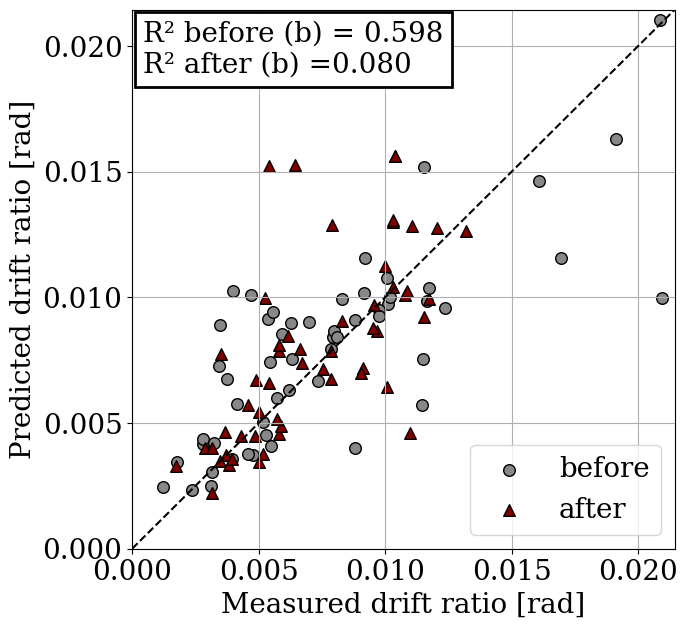

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

target_name=["theta_y","theta_c","theta_u","V_y","V_c","V_u","theta_E","V_E"]
guide = np.max([np.max(y_test_t),np.max(y_pred_t),np.max(y_test_c),np.max(y_pred_c)])*1.02
line_data = [0.0, guide]
line_test = [0.0, guide]
plt.figure(figsize=(7, 7))
plt.rc('font', size=20)
plt.margins(x=0, y=0)

actual_values = y_test_t
predicted_values = y_pred_t
r_squared = r2_score(actual_values, predicted_values)

actual_values_c = y_test_c
predicted_values_c = y_pred_c
r_squared_c = r2_score(actual_values_c, predicted_values_c)

ax = plt.scatter(actual_values, predicted_values, color="black", s=70, edgecolor="black", facecolors="#888888")
ax.set_label('before')
ax1 = plt.scatter(actual_values_c, predicted_values_c, color="#880000", s=70, marker="^", edgecolor="black", facecolors="#800000")
ax1.set_label('after')

plt.xlabel("Measured drift ratio ​[rad]​")
plt.ylabel("Predicted drift ratio [rad]​​")
# plt.xlabel("Test values ​[kN]​")
# plt.ylabel("Predicted values ​[kN]​")

plt.plot(line_data, line_data, color="black", linestyle='dashed')
plt.legend(loc="lower right")
plt.grid()
text = f"R-squared before: {r2_before:.2f}\nR-squared after: {r2_after:.2f}"
bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2)
plt.text(0.02, 0.98, f"R² before (b) = {r_squared:.3f}\nR² after (b) ={r_squared_c:.3f}",
         bbox=bbox_props, transform=plt.gca().transAxes, ha="left", va="top")
plt.xticks(np.arange(0, guide, 0.005))
plt.yticks(np.arange(0, guide, 0.005))
plt.show()


## 특징추출@@@@@@

In [ ]:
# target_num = 4
# X, y = data_input(target_num)

# Assuming you have a preprocessed dataset 'X' and target 'y'
# X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=None,shuffle=True)
X_test=X_clean.loc[df_index_test,:]
y_test=y_clean.loc[df_index_test]
X_train=X_clean.loc[df_index_train,:]
y_train=y_clean.loc[df_index_train]
# Initialize and train an XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=None)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=None)

# Initialize RFECV with cross-validation generator and scoring metric
rfecv = RFECV(estimator=model, cv=kf, scoring='neg_mean_squared_error')

# Fit RFECV on your dataset
rfecv.fit(X_clean, y_clean)

# Get the optimal number of features
optimal_num_features = rfecv.n_features_


NameError: ignored

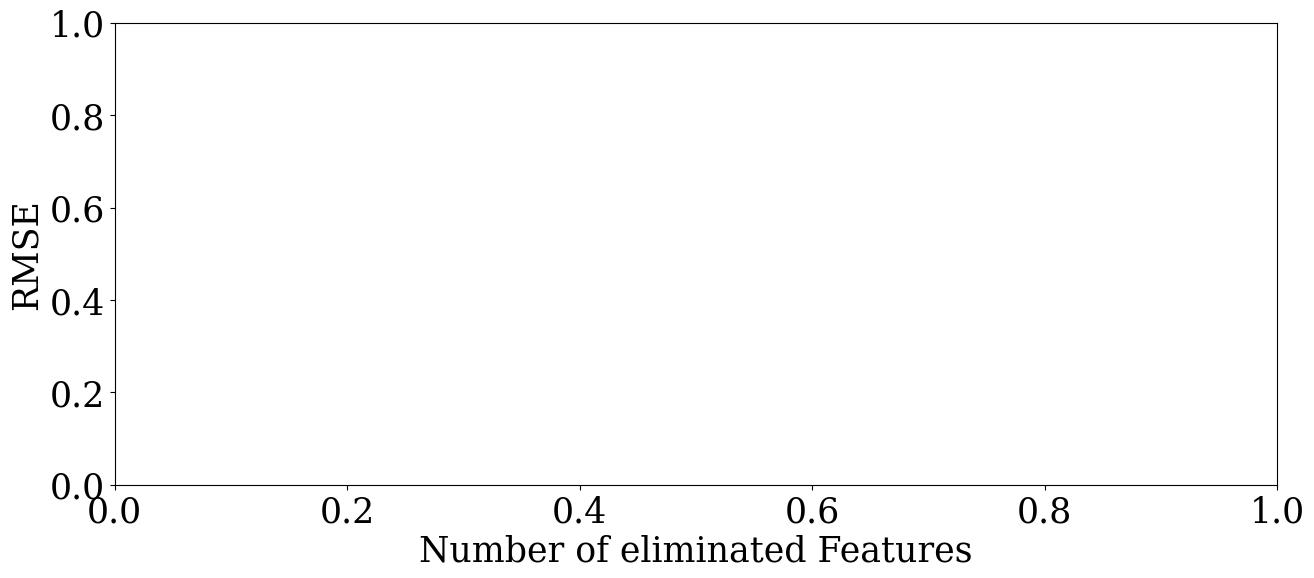

In [ ]:
# Plot the number of features vs. cross-validation scores
plt.figure(figsize=(15, 6))
plt.rc('font', size=25)
plt.xlabel("Number of eliminated Features")
plt.ylabel("RMSE")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), np.sqrt(-rfecv.cv_results_['mean_test_score']), marker='o', linestyle='-', linewidth=3)
# plt.title("RFECV: Optimal Number of Features")
plt.xticks(np.arange(1, len(rfecv.cv_results_['mean_test_score']) + 1))
plt.grid(True)

# Display the results
print(f"Optimal Number of Features: {optimal_num_features}")

# Optionally, you can fit the model with the optimal features
# X_selected = rfecv.transform(X_clean)
X_selected=X_clean[X_clean.columns[rfecv.support_]]
# Show the plot
plt.show()

In [ ]:
X_fs=X_selected
# X_train, X_test, y_train, y_test_fs = train_test_split(X_fs, y, test_size=0.2, random_state=None,shuffle=True)
X_test_fs=X_fs.loc[df_index_test,:]
y_test_fs=y_clean.loc[df_index_test]
X_train_fs=X_fs.loc[df_index_train,:]
y_train_fs=y_clean.loc[df_index_train]
# Initialize and train an XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=None)
model.fit(X_train_fs, y_train_fs)
# Make predictions on the test set
y_pred_fs = model.predict(X_test_fs)
r2_after= r2_score(y_test, y_pred_fs)

In [ ]:
y_test_bf,y_pred_bf,y_test_fsi,y_pred_fsi =inverse_transe(target_num,y_test,y_pred,y_test_fs,y_pred_fs)
r2_before= r2_score(y_test_c, y_pred_c)
r2_after= r2_score(y_test_fsi, y_pred_fsi)
print(r2_before)
print(r2_after)

0.07951551842961668
0.1364586714425664


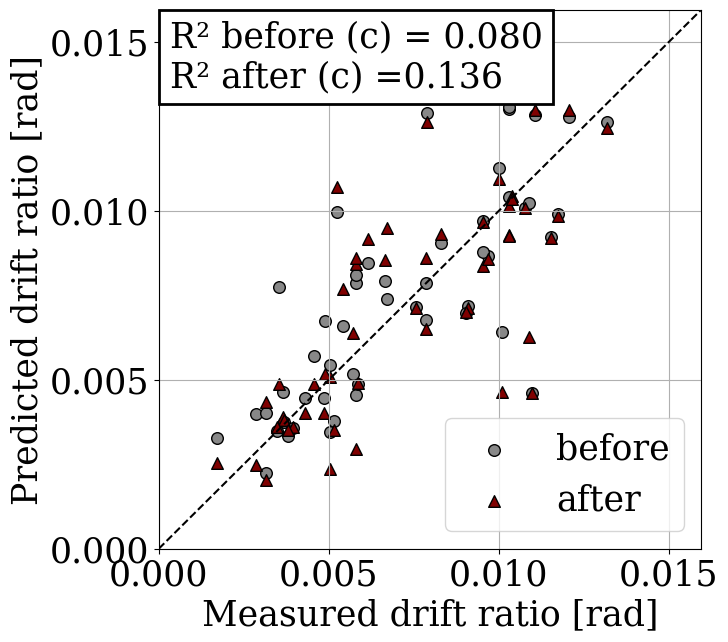

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

target_name=["theta_y","theta_c","theta_u","V_y","V_c","V_u","theta_E","V_E"]
guide = np.max([np.max(y_test_c),np.max(y_pred_c),np.max(y_test_fsi),np.max(y_pred_fsi)])*1.02
line_data = [0.0, guide]
line_test = [0.0, guide]
plt.figure(figsize=(7,7))
plt.rc('font', size=25)
plt.margins(x=0, y=0)

actual_values_c = y_test_c
predicted_values_c = y_pred_c
r_squared = r2_score(actual_values_c, predicted_values_c)

actual_values_fs = y_test_fsi
predicted_values_fs = y_pred_fsi
r_squared_fs = r2_score(actual_values_fs, predicted_values_fs)

ax = plt.scatter(actual_values_c, predicted_values_c, color="black", s=70, edgecolor="black", facecolors="#888888")
ax.set_label('before')
ax1 = plt.scatter(actual_values_fs, predicted_values_fs, color="#880000", s=70, marker="^", edgecolor="black", facecolors="#800000")
ax1.set_label('after')

plt.xlabel("Measured drift ratio ​[rad]​")
plt.ylabel("Predicted drift ratio ​[rad]​")

plt.plot(line_data, line_data, color="black", linestyle='dashed')
plt.legend(loc="lower right")
plt.grid()
text = f"R-squared before: {r2_before:.2f}\nR-squared after: {r2_after:.2f}"
bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2)
plt.text(0.02, 0.98, f"R² before (c) = {r_squared:.3f}\nR² after (c) ={r_squared_fs:.3f}",
         bbox=bbox_props, transform=plt.gca().transAxes, ha="left", va="top")
plt.xticks(np.arange(0, guide, 0.005))
plt.yticks(np.arange(0, guide, 0.005))
plt.show()

## 파라메터 튜닝@@@@@@

In [ ]:
# target_num = 2
# X, y = data_input(target_num)
X=X_fs
y=y_clean
# # Assuming you have a preprocessed dataset 'X' and target 'y'
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None,shuffle=True)
X_test=X.loc[df_index_test,:]
y_test=y.loc[df_index_test]
X_train=X.loc[df_index_train,:]
y_train=y.loc[df_index_train]
# Initialize and train an XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=None)
model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = model.predict(X_test)
r2_before= r2_score(y_test, y_pred)
# Calculate residuals
print(r2_before)

0.23130450495885857


In [ ]:
model_hype_result=tuning(X_train,y_train,X_test,y_test,model)
# parameters

In [ ]:
# Initialize and train an XGBoost regressor
model_hype_result.fit(X_train, y_train)
# Make predictions on the test set
y_pred_t = model_hype_result.predict(X_test)
r2_after= r2_score(y_test, y_pred_t)
print(r2_after)

0.4320863252659297


In [ ]:
y_test,y_pred,y_test_t,y_pred_t =inverse_transe(target_num,y_test,y_pred,y_test,y_pred_t)
r2_before= r2_score(y_test_fsi, y_pred_fsi)
r2_after= r2_score(y_test_t, y_pred_t)
print(r2_before)
print(r2_after)

0.23130451508826455
0.4320863103952668


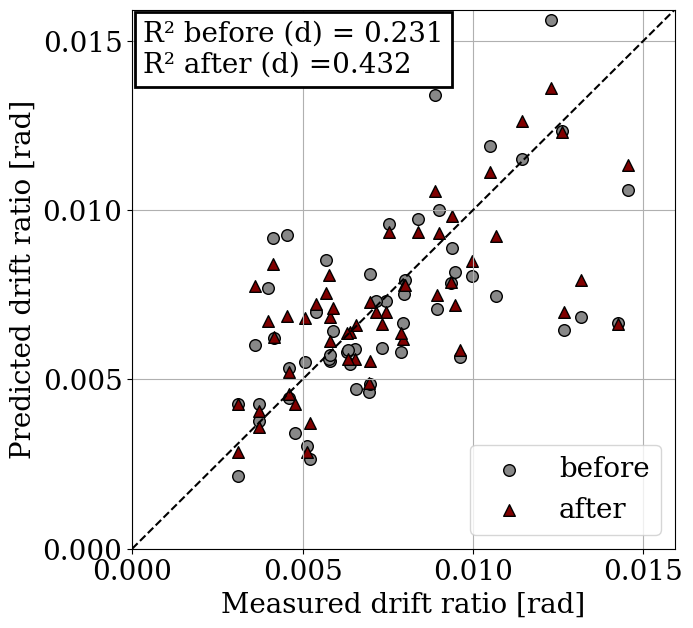

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

target_name=["theta_y","theta_c","theta_u","V_y","V_c","V_u","theta_E","V_E"]
guide = np.max([np.max(y_test_fsi),np.max(y_pred_fsi),np.max(y_test_t),np.max(y_pred_t)])*1.02
line_data = [0.0, guide]
line_test = [0.0, guide]
plt.figure(figsize=(7,7))
plt.rc('font', size=20)
plt.margins(x=0, y=0)
actual_values_fsi = y_test_fsi
predicted_values_fsi = y_pred_fsi
r_squared = r2_score(actual_values_fsi, predicted_values_fsi)

actual_values_t = y_test_t
predicted_values_t = y_pred_t
r_squared_t = r2_score(actual_values_t, predicted_values_t)

ax = plt.scatter(actual_values_fsi, predicted_values_fsi, color="black", s=70, edgecolor="black", facecolors="#888888")
ax.set_label('before')
ax1 = plt.scatter(actual_values_t, predicted_values_t, color="#880000", s=70, marker="^", edgecolor="black", facecolors="#800000")
ax1.set_label('after')

plt.xlabel("Measured drift ratio ​[rad]​")
plt.ylabel("Predicted drift ratio ​[rad]​")

plt.plot(line_data, line_data, color="black", linestyle='dashed')
plt.legend(loc="lower right")
plt.grid()
text = f"R-squared before: {r2_before:.2f}\nR-squared after: {r2_after:.2f}"
bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2)
plt.text(0.02, 0.98, f"R² before (d) = {r_squared:.3f}\nR² after (d) ={r_squared_t:.3f}",
         bbox=bbox_props, transform=plt.gca().transAxes, ha="left", va="top")
plt.xticks(np.arange(0, guide, 0.005))
plt.yticks(np.arange(0, guide, 0.005))

plt.show()

# 단계별 모델 성능 개선 비교

이상치제거

In [ ]:
df = pd.read_csv("df_278samples_1026.csv", encoding='cp949')
df_output=df.iloc[:, -8:]
df_input=df.iloc[:,:-8]
X = df_input
y = df_output.iloc[:,target_num]
r2_before_100=[]
for _ in range(100):
  # Assuming you have a preprocessed dataset 'X' and target 'y'
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None,shuffle=True)

  # Initialize and train an XGBoost regressor
  model = xgb.XGBRegressor(objective='reg:squarederror', random_state=None)
  model.fit(X_train, y_train)
  # Make predictions on the test set
  y_pred = model.predict(X_test)
  r2_before= r2_score(y_test, y_pred)
  r2_before_100.append(r2_before)
np.mean(r2_before_100)

0.4740369839860319

In [ ]:
pd.DataFrame(r2_before_100).to_excel("orininal_database.xlsx")

In [ ]:
target_num=0
X,y=data_input(target_num)
for _ in range(100):
  # Assuming you have a preprocessed dataset 'X' and target 'y'
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None,shuffle=True)

  # Initialize and train an XGBoost regressor
  model = xgb.XGBRegressor(objective='reg:squarederror', random_state=None)
  model.fit(X_train, y_train)
  # Make predictions on the test set
  y_pred = model.predict(X_test)
  r2_before= r2_score(y_test, y_pred)
  # Calculate residuals
  residuals = y_test - y_pred

  # Calculate the Z-scores of residuals
  z_scores = zscore(residuals)

  # Define a threshold for outlier detection (e.g., Z-score > 3)
  threshold = 1.5

  # Identify outliers

  outliers = (np.abs(z_scores) > threshold)
  # Get the row indices where the condition is True
  # outliers_index= outliers.any(axis=1).nonzero()[0]
  outliers = np.where(np.abs(z_scores) > threshold)[0]
  outliers_index=X_test.index[outliers]

  X_clean = X.drop(index=outliers_index)
  y_clean = y.drop(index=outliers_index)

  X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clean, y_clean, test_size=0.2, random_state=None,shuffle=True)

  # Initialize and train an XGBoost regressor
  model_c = xgb.XGBRegressor(objective='reg:squarederror', random_state=None)
  model_c.fit(X_train_c, y_train_c)

  # Make predictions on the test set
  y_pred_c = model_c.predict(X_test_c)

  y_test,y_pred,y_test_c,y_pred_c =inverse_transe(target_num,y_test,y_pred,y_test_c,y_pred_c)
  r2_before= r2_score(y_test, y_pred)
  r2_after= r2_score(y_test_c, y_pred_c)

  r2_before_100.append(r2_before)
  r2_after_100.append(r2_after)

In [ ]:
print(np.mean(r2_before_100))
print(np.mean(r2_after_100))

0.7974839627297107
0.8321756625465511


특징추출

In [ ]:
r2_before_rf_100=[]
r2_after_rf_100=[]
for _ in range(50):
  X=X_clean
  y=y_clean
  # Assuming you have a preprocessed dataset 'X' and target 'y'
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None,shuffle=True)

  # Initialize and train an XGBoost regressor
  model = xgb.XGBRegressor(objective='reg:squarederror', random_state=None)
  model.fit(X_train, y_train)
  # Make predictions on the test set
  y_pred = model.predict(X_test)
  r2_before= r2_score(y_test, y_pred)

  kf = KFold(n_splits=10, shuffle=True, random_state=None)

  # Initialize RFECV with cross-validation generator and scoring metric
  rfecv = RFECV(estimator=model, cv=kf, scoring='neg_mean_squared_error')

  # Fit RFECV on your dataset
  rfecv.fit(X, y)
  X_selected = rfecv.transform(X)
  X_fs=pd.DataFrame(X_selected)
  X_train, X_test, y_train, y_test_fs = train_test_split(X_fs, y, test_size=0.2, random_state=None,shuffle=True)

  # Initialize and train an XGBoost regressor
  model = xgb.XGBRegressor(objective='reg:squarederror', random_state=None)
  model.fit(X_train, y_train)
  # Make predictions on the test set
  y_pred_fs = model.predict(X_test)
  r2_after= r2_score(y_test, y_pred)

  y_test,y_pred,y_test_fs,y_pred_fs =inverse_transe(target_num,y_test,y_pred,y_test_fs,y_pred_fs)
  r2_before= r2_score(y_test, y_pred)
  r2_after= r2_score(y_test_fs, y_pred_fs)
  r2_before_rf_100.append(r2_before)
  r2_after_rf_100.append(r2_after)

튜닝

In [ ]:
r2_before_tu_100=[]
r2_after_tu_100=[]
for _ in range(50):
  X=X_fs
  y=y
  # Assuming you have a preprocessed dataset 'X' and target 'y'
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None,shuffle=True)

  # Initialize and train an XGBoost regressor
  model = xgb.XGBRegressor(objective='reg:squarederror', random_state=None)
  model.fit(X_train, y_train)
  # Make predictions on the test set
  y_pred = model.predict(X_test)
  r2_before= r2_score(y_test, y_pred)
  # Calculate residuals
  model_fs1=model
  model_hype_result=tuning(X_train,y_train,X_test,y_test,model_fs1)

  # Initialize and train an XGBoost regressor
  model_hype_result.fit(X_train, y_train)
  # Make predictions on the test set
  y_pred_t = model_hype_result.predict(X_test)
  r2_after= r2_score(y_test, y_pred_t)

  y_test,y_pred,y_test_t,y_pred_t =inverse_transe(target_num,y_test,y_pred,y_test,y_pred_t)
  r2_before= r2_score(y_test, y_pred)
  r2_after= r2_score(y_test_t, y_pred_t)
  r2_before_tu_100.append(r2_before)
  r2_after_tu_100.append(r2_after)

# 한번에 50회

In [ ]:
target_num=0
r2_before_100=[]
r2_after_sc_100=[]
r2_after_oe_100=[]
r2_after_fs_100=[]
r2_after_tu_100=[]

for _ in range(100):
 ##오리지널##
  target_num=0
  df = pd.read_csv("df_275samples_1030.csv", encoding='cp949')
  df_output=df.iloc[:, -8:]
  df_input=df.iloc[:,:-8]
  X=df_input
  y=df_output.iloc[:,target_num]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None,shuffle=True)
  df_index_test=sorted(X_test.index.tolist())
  df_index_train=sorted(X_train.index.tolist())
  model = xgb.XGBRegressor(objective='reg:squarederror', random_state=None)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  r2_before= r2_score(y_test, y_pred)
  r2_before_100.append(r2_before)

 ##데이터스케일링##
  X,y=data_input(target_num)
  X_test=X.loc[df_index_test,:]
  y_test=y.loc[df_index_test]
  X_train=X.loc[df_index_train,:]
  y_train=y.loc[df_index_train]
  model_s = xgb.XGBRegressor(objective='reg:squarederror', random_state=None)
  model_s.fit(X_train, y_train)
  # Make predictions on the test set
  y_pred = model_s.predict(X_test)
  r2_after_sc= r2_score(y_test, y_pred)
  r2_after_sc_100.append(r2_after_sc)

 ##이상치제거##

  residuals = y_test - y_pred
  z_scores = zscore(residuals)
  threshold = 1.5
  outliers = (np.abs(z_scores) > threshold)
  outliers = np.where(np.abs(z_scores) > threshold)[0]
  outliers_index=X_test.index[outliers]
  X_clean = X.drop(index=outliers_index)
  y_clean = y.drop(index=outliers_index)
  X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clean, y_clean, test_size=0.2, random_state=None,shuffle=True)
  df_index_test=sorted(X_test_c.index.tolist())
  df_index_train=sorted(X_train_c.index.tolist())
  model_c = xgb.XGBRegressor(objective='reg:squarederror', random_state=None)
  model_c.fit(X_train_c, y_train_c)
  y_pred_c = model_c.predict(X_test_c)
  y_test,y_pred,y_test_c,y_pred_c =inverse_transe(target_num,y_test,y_pred,y_test_c,y_pred_c)
  r2_after_oe= r2_score(y_test_c, y_pred_c)
  r2_after_oe_100.append(r2_after_oe)

 ##특징추출##
  X_test=X_clean.loc[df_index_test,:]
  y_test=y_clean.loc[df_index_test]
  X_train=X_clean.loc[df_index_train,:]
  y_train=y_clean.loc[df_index_train]
  model_c = xgb.XGBRegressor(objective='reg:squarederror', random_state=None)
  model_c.fit(X_train, y_train)
  y_pred = model_c.predict(X_test)

  kf = KFold(n_splits=10, shuffle=True, random_state=None)
  rfecv = RFECV(estimator=model_c, cv=kf, scoring='neg_mean_squared_error')
  rfecv.fit(X_clean, y_clean)
  X_selected=X_clean[X_clean.columns[rfecv.support_]]
  X_fs=pd.DataFrame(X_selected)
  X_test=X_fs.loc[df_index_test,:]
  y_test=y_clean.loc[df_index_test]
  X_train=X_fs.loc[df_index_train,:]
  y_train=y_clean.loc[df_index_train]
  model_fs = xgb.XGBRegressor(objective='reg:squarederror', random_state=None)
  model_fs.fit(X_train, y_train)

  y_pred_fs = model_fs.predict(X_test)
  y_test,y_pred,y_test,y_pred_fs =inverse_transe(target_num,y_test,y_pred,y_test,y_pred_fs)
  r2_after_fs= r2_score(y_test, y_pred_fs)
  r2_after_fs_100.append(r2_after_fs)

##튜닝##
  X_test=X_fs.loc[df_index_test,:]
  y_test=y_clean.loc[df_index_test]
  X_train=X_fs.loc[df_index_train,:]
  y_train=y_clean.loc[df_index_train]
  model_t= xgb.XGBRegressor(objective='reg:squarederror', random_state=None)
  model_t.fit(X_train, y_train)
  y_pred = model_t.predict(X_test)

  model_hype_result=tuning(X_train,y_train,X_test,y_test,model_t)

  model_hype_result.fit(X_train, y_train)
  y_pred_t = model_hype_result.predict(X_test)
  y_test,y_pred,y_test,y_pred_t =inverse_transe(target_num,y_test,y_pred,y_test,y_pred_t)
  r2_after= r2_score(y_test, y_pred_t)
  r2_after_tu_100.append(r2_after)

In [ ]:
data=[r2_before_100,r2_after_sc_100,r2_after_oe_100,r2_after_fs_100,r2_after_tu_100] # 다음에는 저장된거 불러오기
pd.DataFrame(data).to_excel("genernal_100times_1030.xlsx")

In [ ]:
# data=[r2_before_100,r2_after_sc_100,r2_after_oe_100,r2_after_fs_100,r2_after_tu_100] # 다음에는 저장된거 불러오기

data = pd.read_csv("genernal_100times_1030.csv", encoding='cp949')


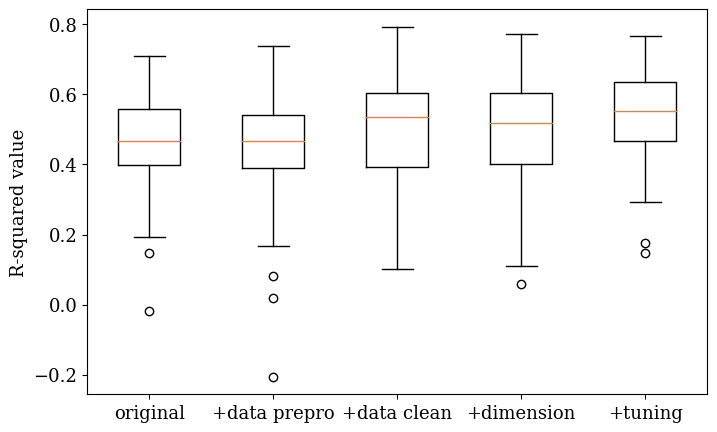

In [ ]:
plt.figure(figsize=(8, 5))
plt.rc('font', size=13)
plt.boxplot(data, labels=['original', '+data prepro','+data clean','+dimension','+tuning'])
plt.title('')
plt.ylabel('R-squared value')
plt.xlabel('')
plt.show()

In [ ]:
pd.DataFrame(data).to_excel("general_model_performance_Vy.xlsx")

# 성능평가

## 정확도 측정

test set 100회 중 1등 뽑기

In [ ]:
X_train,y_train,X_test,y_test,df_index_train,df_index_test,max_r2,r2_test_hype_result=model_eval_100(X_fs1,y_fs1,model_hype_result)

NameError: ignored

교차검증 10회 중 1등 뽑기 (0.7이상 합격)

In [ ]:
max_r2=np.max(r2_test_hype_result)
cv_results_r2_hype=cv_model_eval(model_hype_result,X_fs1,y_fs1) # 교차검증 결과값
print(np.max(r2_test_hype_result))
print(np.max(cv_results_r2_hype))

## 결과 뽑기

예측값, 실제값 비교 (train, test set)

In [ ]:
result_df1,result_df2=result(X_train,y_train,X_test,y_test,df_index_train,df_index_test,model_hype_result) # 예측값

# trian set : result_df1
# test set  : result_df2

예측값, 실제값 역변환 (train, test set)

In [ ]:
inverse_result1=inverse_transe(result_df1,target_num)
inverse_result2=inverse_transe(result_df2,target_num) # 예측값 역변환

# target별 예측 대 실제 비교 그림 그리기

## train set

In [ ]:
# Create a list of subject names
subjects = list(inverse_result1.index)
predicted=inverse_result1.iloc[:,3]
actual=inverse_result1.iloc[:,2]
# Set the width of the bars
bar_width = 0.35

# Set the position of the bars on the x-axis
r1 = np.arange(len(subjects))

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10,10))
plt.rc('font', size=10)

# Create bars for the overlapping part in gray color
ax.barh(r1, np.minimum(predicted, actual), height=bar_width, color='lightgray', label='Overlap')
# Create bars for the predicted values larger than actual values in orange color
ax.barh(r1, np.maximum(predicted - actual, 0), height=bar_width, left=np.minimum(predicted, actual), color='tab:orange', label='Predicted > Actual')
# Create bars for the actual values larger than predicted values in blue color
ax.barh(r1, np.maximum(actual - predicted, 0), height=bar_width, left=np.minimum(predicted, actual), color='tab:blue', label='Actual > Predicted')

# Add labels, titles, and legends
ax.set_xlabel('Value', fontsize=12)
ax.set_ylabel('Number of Specimens',fontsize=12)
ax.set_title('Actual vs. Predicted Values',fontsize=12)
ax.set_yticks(r1)
ax.set_yticklabels(subjects)
ax.legend()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

target_name=["DS1", "DS2","DS3","DS4", "Vy","Vu","DS4/DS2"]
guide = np.max(np.max(inverse_result1.iloc[:,2:4]))*1.1
line_data = [0.0, guide]
line_test = [0.0, guide * 0.75]
plt.figure(figsize=(10, 10))
plt.rc('font', size=14)
plt.margins(x=0, y=0)

actual_values = inverse_result1.iloc[:,2]
predicted_values = inverse_result1.iloc[:,3]
r_squared = r2_score(actual_values, predicted_values)

ax = plt.scatter(actual_values, predicted_values, color="blue", s=70)
ax.set_label(target_name[target_num])
plt.xlabel("Test values ​​[rad]")
plt.ylabel("Predicted values ​​[rad]")

plt.plot(line_data, line_data, color="red", linestyle='dashed')
plt.legend(loc="lower right")
plt.grid()

bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2)
plt.text(0.02, 0.98, f"R² = {r_squared:.3f}", fontsize=17,
         bbox=bbox_props, transform=plt.gca().transAxes, ha="left", va="top")

plt.show()


## test set

In [ ]:
# Create a list of subject names
subjects = list(inverse_result2.index)
predicted=inverse_result2.iloc[:,3]
actual=inverse_result2.iloc[:,2]
# Set the width of the bars
bar_width = 0.35

# Set the position of the bars on the x-axis
r1 = np.arange(len(subjects))

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10,10))
plt.rc('font', size=10)

# Create bars for the overlapping part in gray color
ax.barh(r1, np.minimum(predicted, actual), height=bar_width, color='lightgray', label='Overlap')
# Create bars for the predicted values larger than actual values in orange color
ax.barh(r1, np.maximum(predicted - actual, 0), height=bar_width, left=np.minimum(predicted, actual), color='tab:orange', label='Predicted > Actual')
# Create bars for the actual values larger than predicted values in blue color
ax.barh(r1, np.maximum(actual - predicted, 0), height=bar_width, left=np.minimum(predicted, actual), color='tab:blue', label='Actual > Predicted')

# Add labels, titles, and legends
ax.set_xlabel('Value', fontsize=12)
ax.set_ylabel('Number of Specimens',fontsize=12)
ax.set_title('Actual vs. Predicted Values',fontsize=12)
ax.set_yticks(r1)
ax.set_yticklabels(subjects)
ax.legend()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

target_name=["DS1", "DS2","DS3","DS4", "Vy","Vu","DS4/DS2"]
guide = np.max(np.max(inverse_result1.iloc[:,2:4]))*1.1
line_data = [0.0, guide]
line_test = [0.0, guide * 0.75]
plt.figure(figsize=(10, 10))
plt.rc('font', size=14)
plt.margins(x=0, y=0)

actual_values = inverse_result2.iloc[:,2]
predicted_values = inverse_result2.iloc[:,3]
r_squared = r2_score(actual_values, predicted_values)

ax = plt.scatter(actual_values, predicted_values, color="blue", s=70)
ax.set_label(target_name[target_num])
plt.xlabel("Test values ​​[rad]")
plt.ylabel("Predicted values ​​[rad]")

plt.plot(line_data, line_data, color="red", linestyle='dashed')
plt.legend(loc="lower right")
plt.grid()

bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2)
plt.text(0.02, 0.98, f"R² = {r_squared:.3f}", fontsize=17,
         bbox=bbox_props, transform=plt.gca().transAxes, ha="left", va="top")

plt.show()
